# Spectrum offset of different slices
Script written by Ioannis Argyriou (Institute of Astronomy, KU Leuven)
Creation date: October 4th 2018 

This notebook computes the pixel offset of the LWP filter transmission, seen by the MRS, in the different IFU slices.

### > Import modules

In [1]:
import funcs
import mrsobs
from distortionMaps import d2cMapping

import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

### > Set directories

In [2]:
# USER:
user = "yannis" # "yannis"

# Set work directory
# *** Change these to more general folders like"./data_for_notebook_test/" that we can all have
if user == "alvaro":
    workDir = "./"
    
if user == "yannis":
    workDir  = "/Users/ioannisa/Desktop/python/miri_devel/"

cdpDir   = workDir+"cdp_data/"
lvl2path = workDir+"FM_data/LVL2/"

### > Give analysis inputs

In [3]:
# inputs
band = '1C'                     # spectral band under investigation
lamblower,lambupper = 6.5,7.7   # nominal wavelength range of band 1C
ref_slice = 10                  # reference slice
alpha_pos = 0.                  # along-slice position, [arcsec]

### > Import MRS observations

<IPython.core.display.Javascript object>


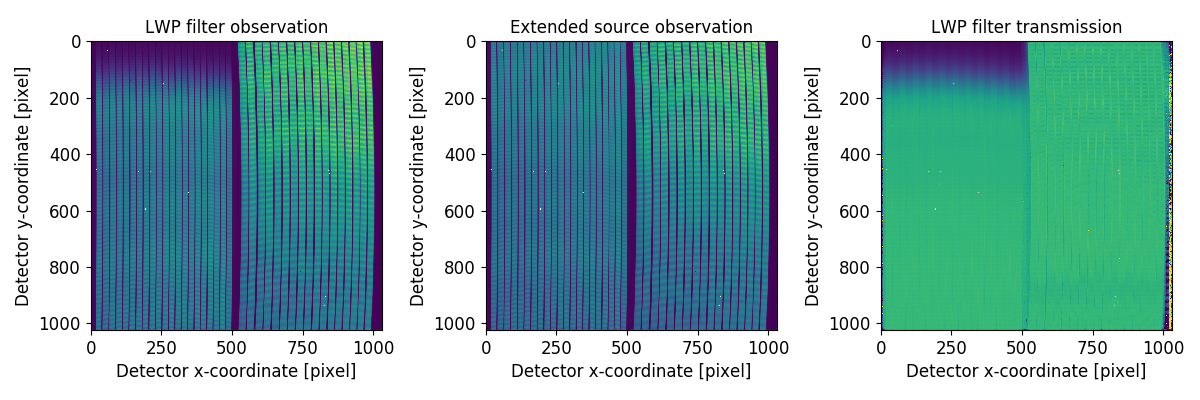

In [5]:
# -->MRS detector images processed with DHAS 9.4.4 miri_sloper only
# lwp_filter_img: LWP filter extended obs (LWP transm x 800K BB), ext_source_img: 800K BB extended source config
# ***** AL: Are these corrected of background? They should be, right? <-- The observations are now background corrected!

lwp_filter_img,ext_source_img,bkg_img = mrsobs.FM_MTS_800K_BB_MRS_OPT_08(lvl2path,wp_filter='LWP',output='img')
lwp_transmission_img = (lwp_filter_img-bkg_img)/(ext_source_img-bkg_img)

# plot
fig,axs = plt.subplots(1,3,figsize=(12,4))
axs[0].imshow(lwp_filter_img)
axs[1].imshow(ext_source_img)
axs[2].imshow(lwp_transmission_img,vmin=0,vmax=1.4)
for plot in range(3):
    axs[plot].set_xlabel('Detector x-coordinate [pixel]',fontsize=12)
    axs[plot].set_ylabel('Detector y-coordinate [pixel]',fontsize=12)
    axs[plot].tick_params(axis='both',labelsize=12)
axs[0].set_title('LWP filter observation',fontsize=12)
axs[1].set_title('Extended source observation',fontsize=12)
axs[2].set_title('LWP filter transmission',fontsize=12)
plt.tight_layout()

### > Determine spectrum offset between the central trace of each MRS IFU slice

In [6]:
# load distortion maps
d2cMaps   = d2cMapping(band,cdpDir)
sliceMap  = d2cMaps['sliceMap']
lambdaMap = d2cMaps['lambdaMap']
alphaMap  = d2cMaps['alphaMap']
nslices   = d2cMaps['nslices']
det_dims  = (1024,1032)

<IPython.core.display.Javascript object>


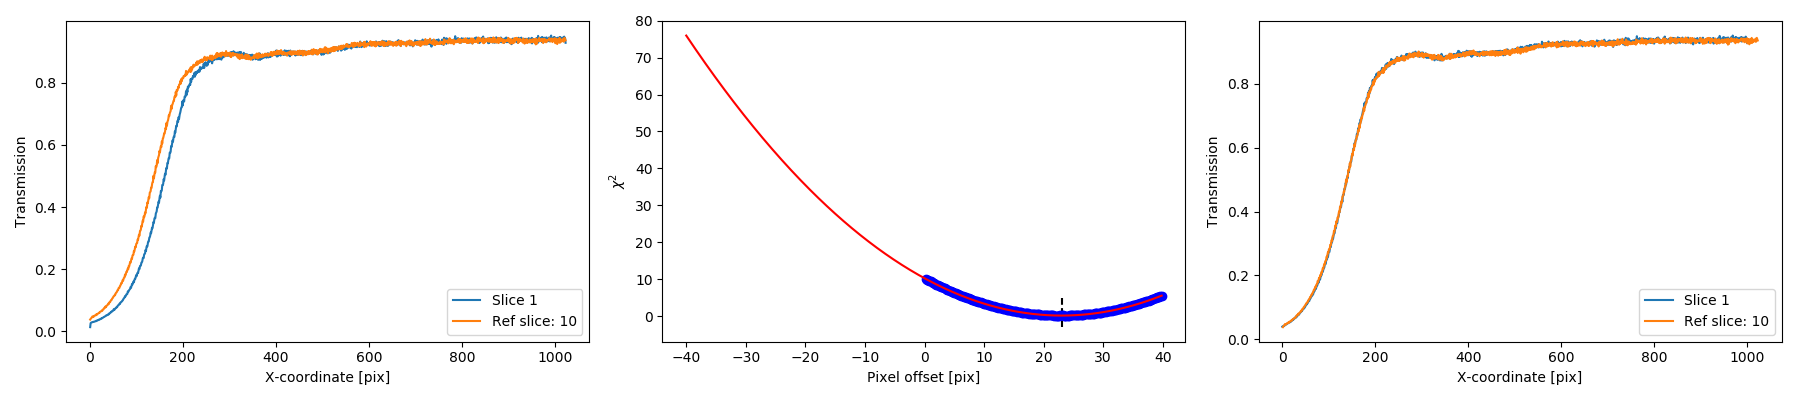

Slice 1
Pixel offset: 23.0pix


<IPython.core.display.Javascript object>


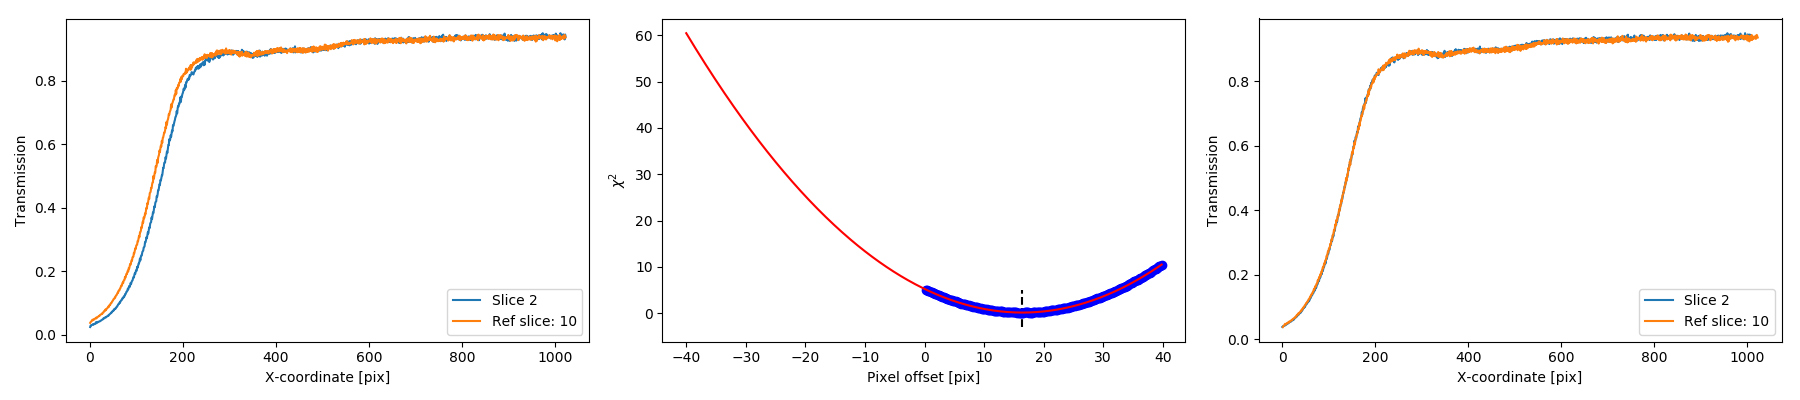

Slice 2
Pixel offset: 16.42pix


<IPython.core.display.Javascript object>


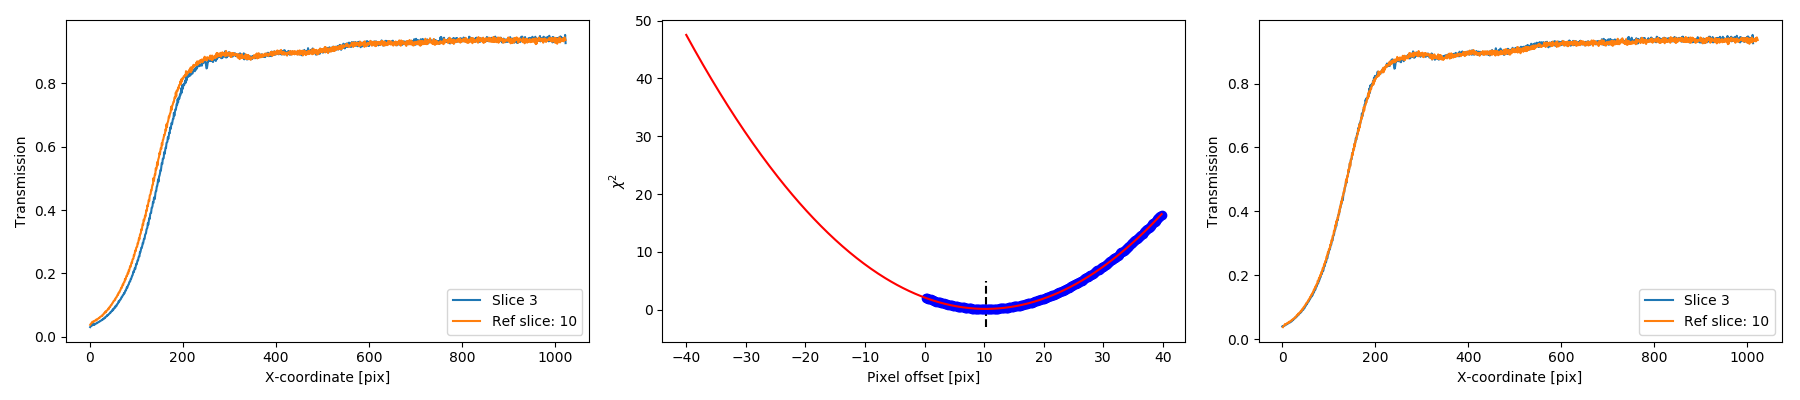

Slice 3
Pixel offset: 10.25pix


<IPython.core.display.Javascript object>


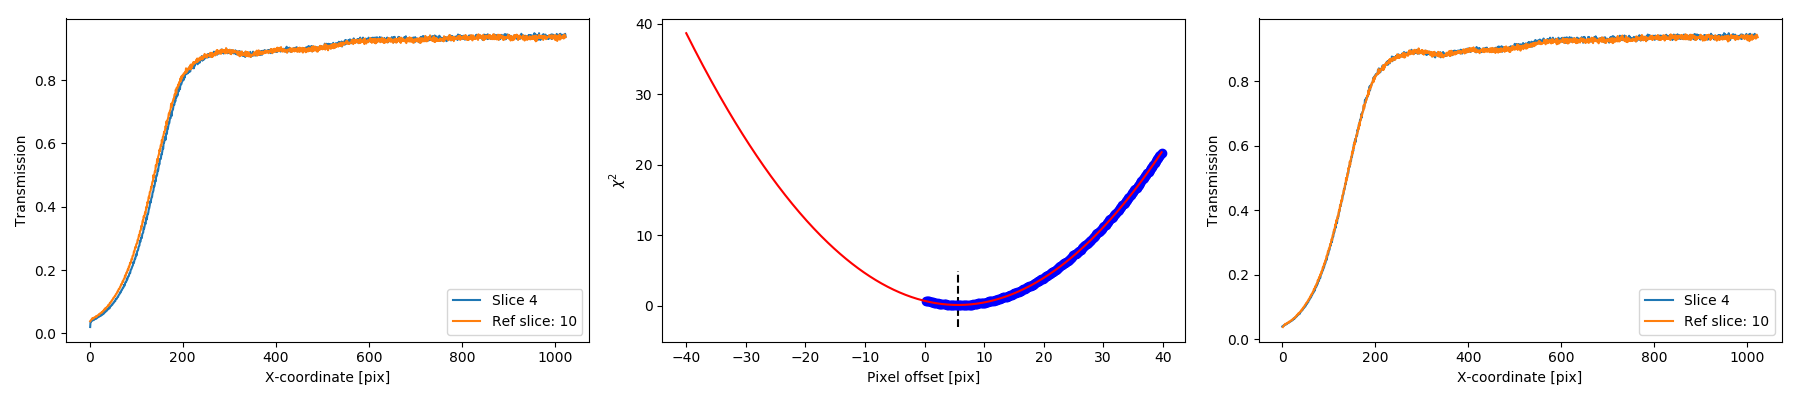

Slice 4
Pixel offset: 5.61pix


<IPython.core.display.Javascript object>


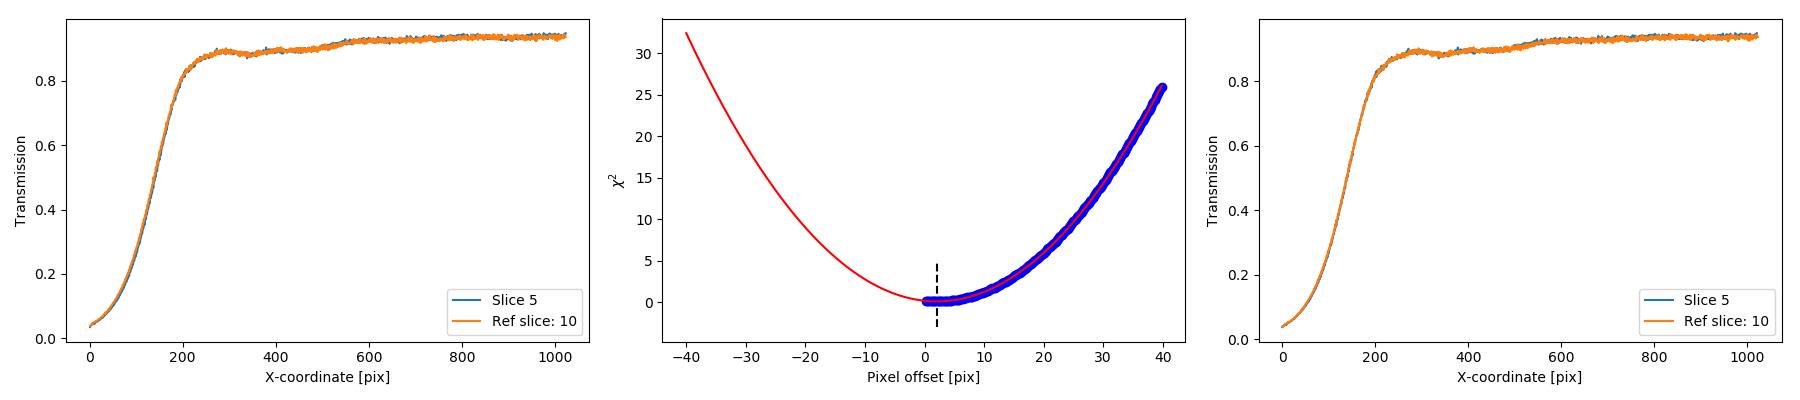

Slice 5
Pixel offset: 2.08pix


<IPython.core.display.Javascript object>


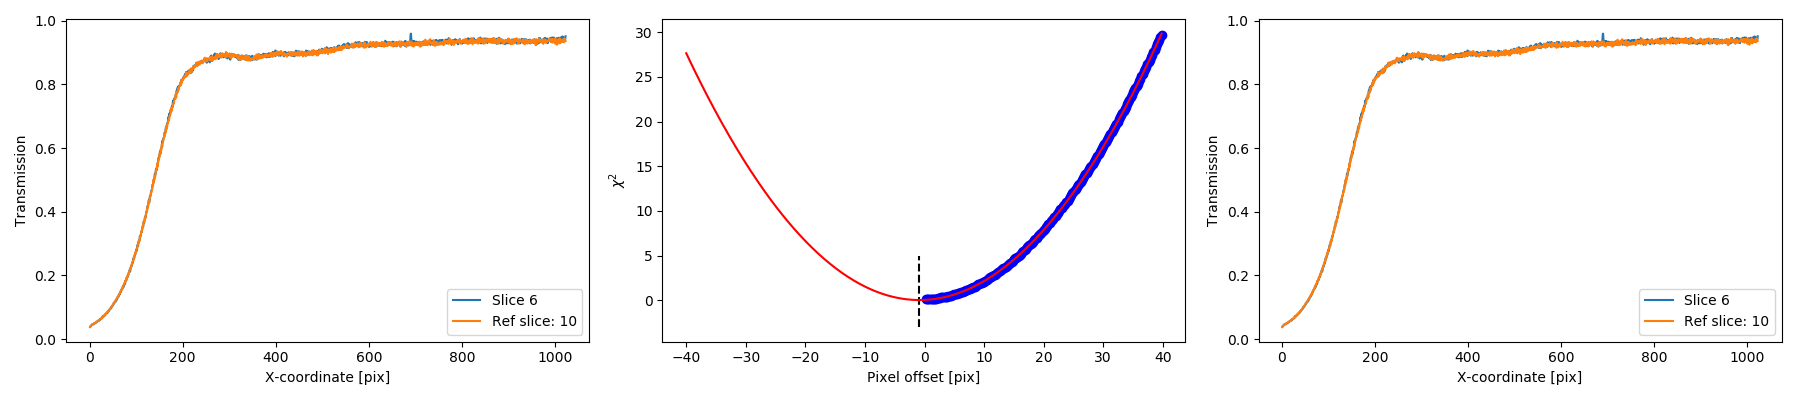

Slice 6
Pixel offset: -0.87pix


<IPython.core.display.Javascript object>


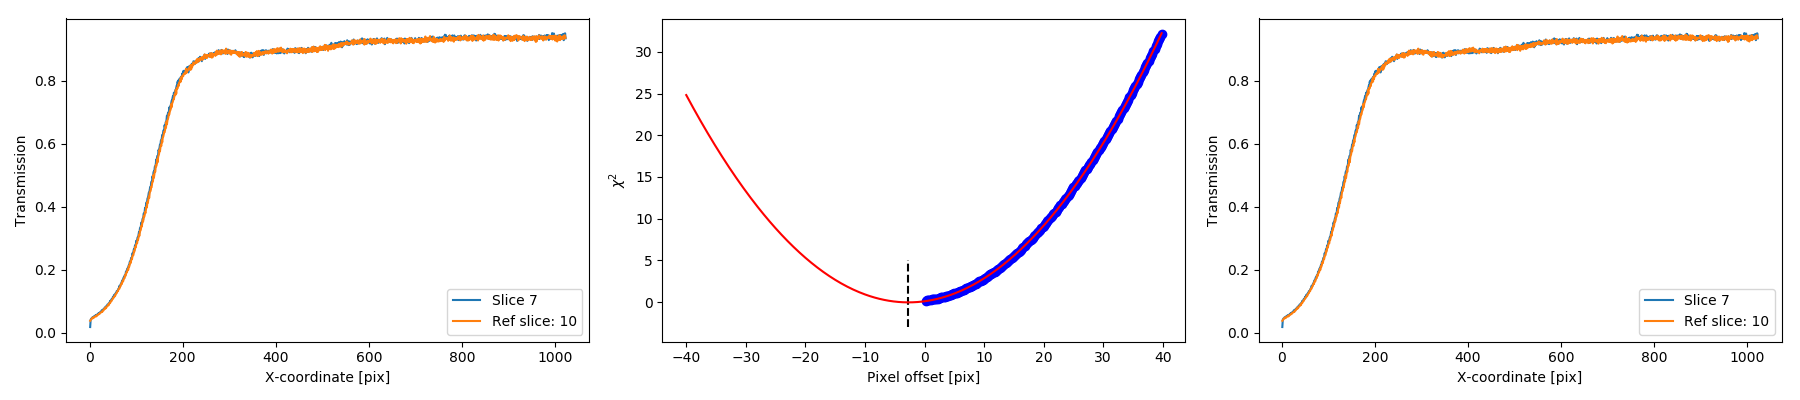

Slice 7
Pixel offset: -2.7pix


<IPython.core.display.Javascript object>


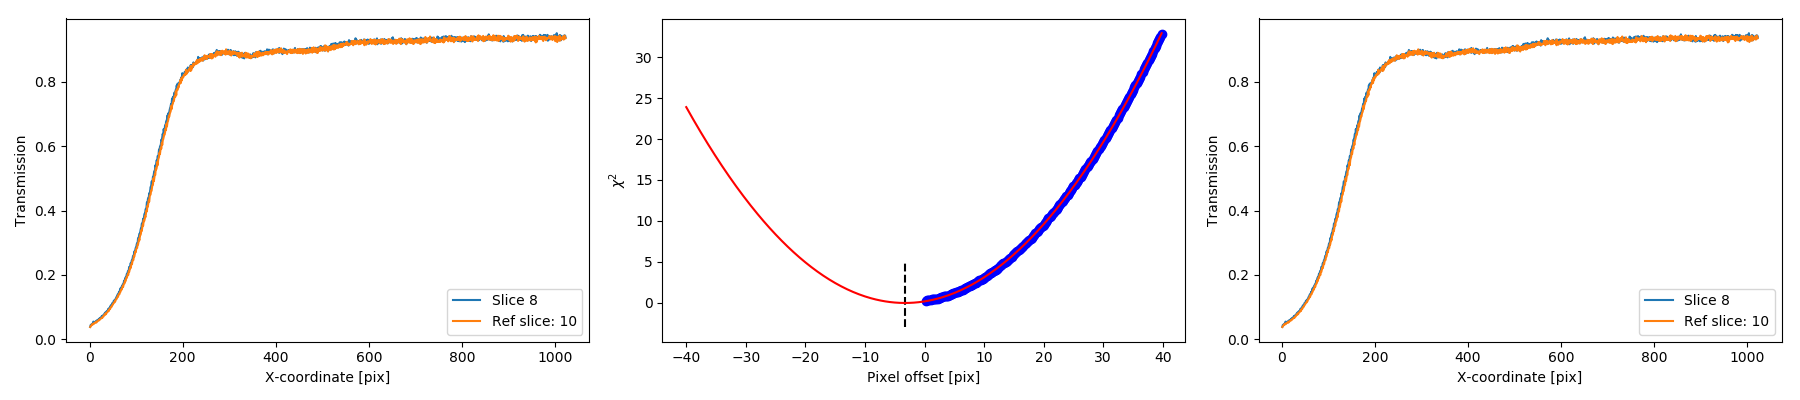

Slice 8
Pixel offset: -3.29pix


<IPython.core.display.Javascript object>


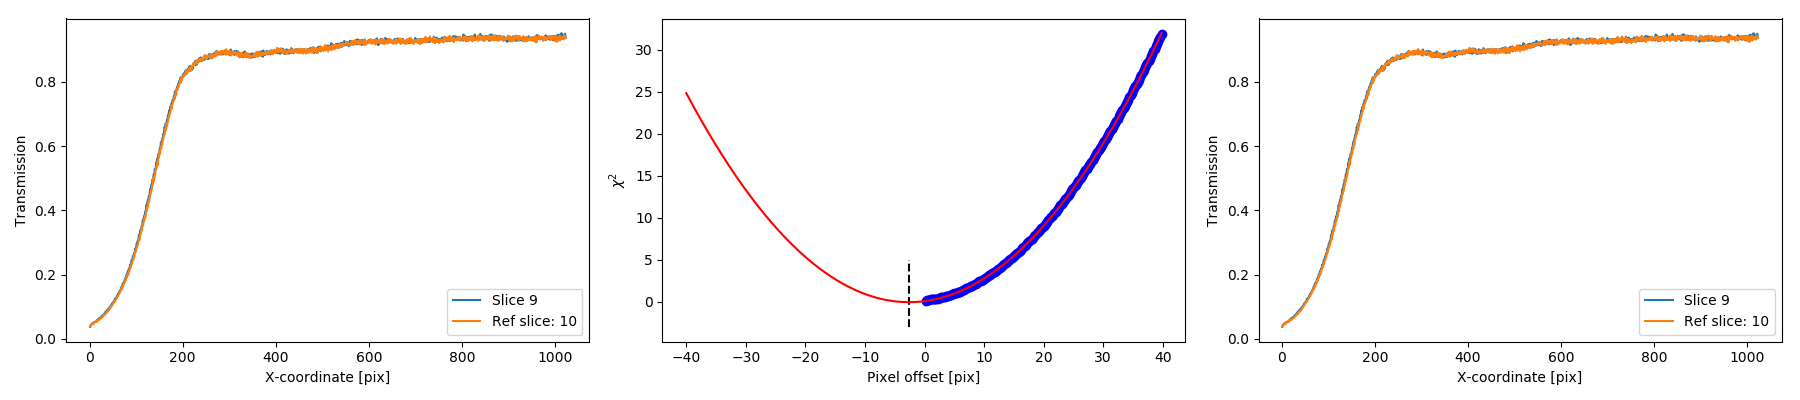

Slice 9
Pixel offset: -2.61pix


<IPython.core.display.Javascript object>


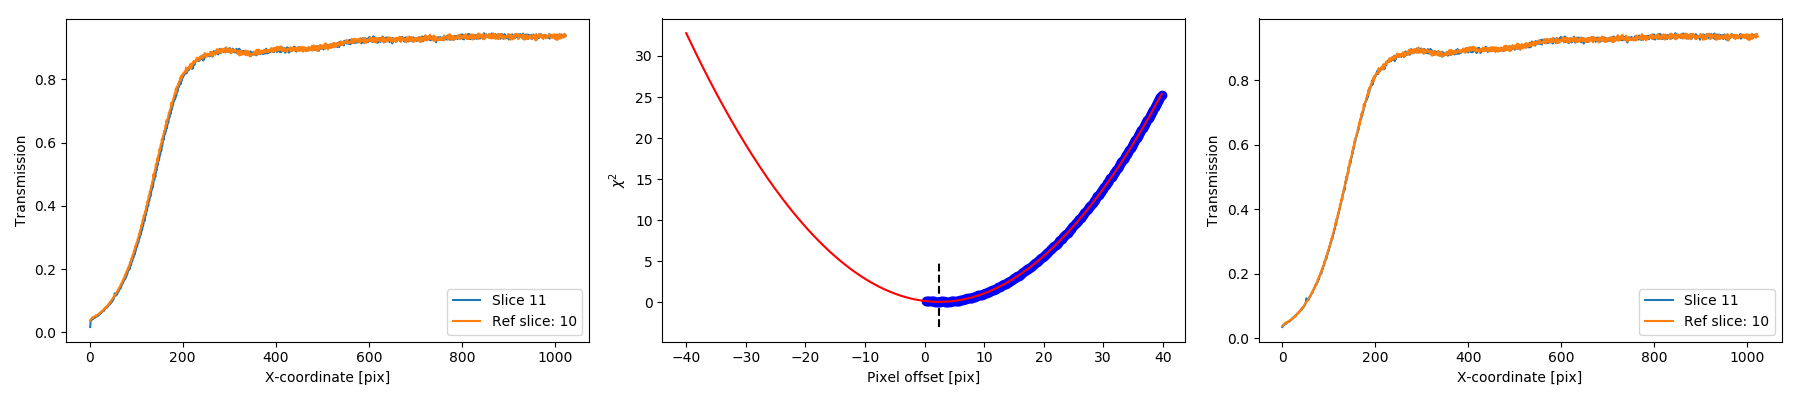

Slice 11
Pixel offset: 2.45pix


<IPython.core.display.Javascript object>


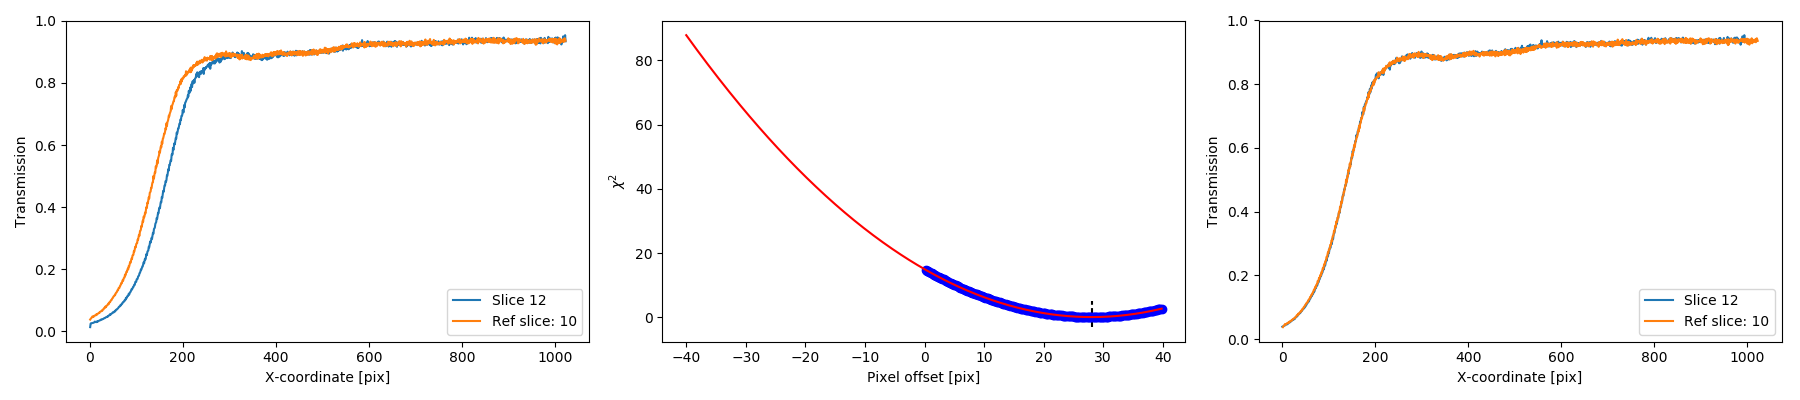

Slice 12
Pixel offset: 28.04pix


<IPython.core.display.Javascript object>


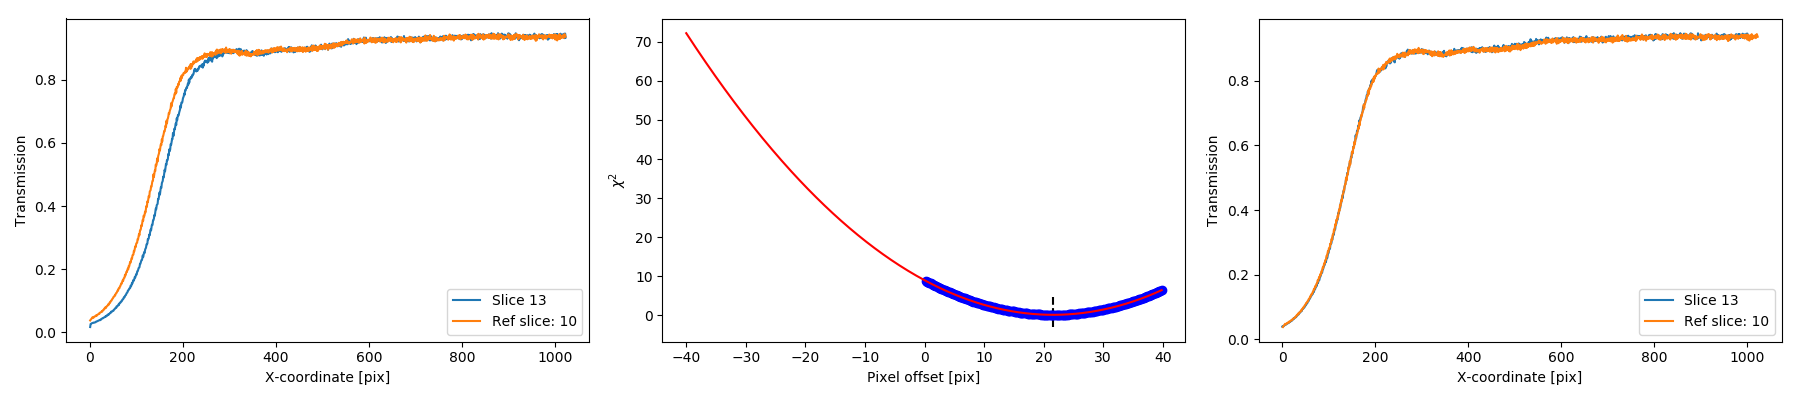

Slice 13
Pixel offset: 21.58pix


<IPython.core.display.Javascript object>


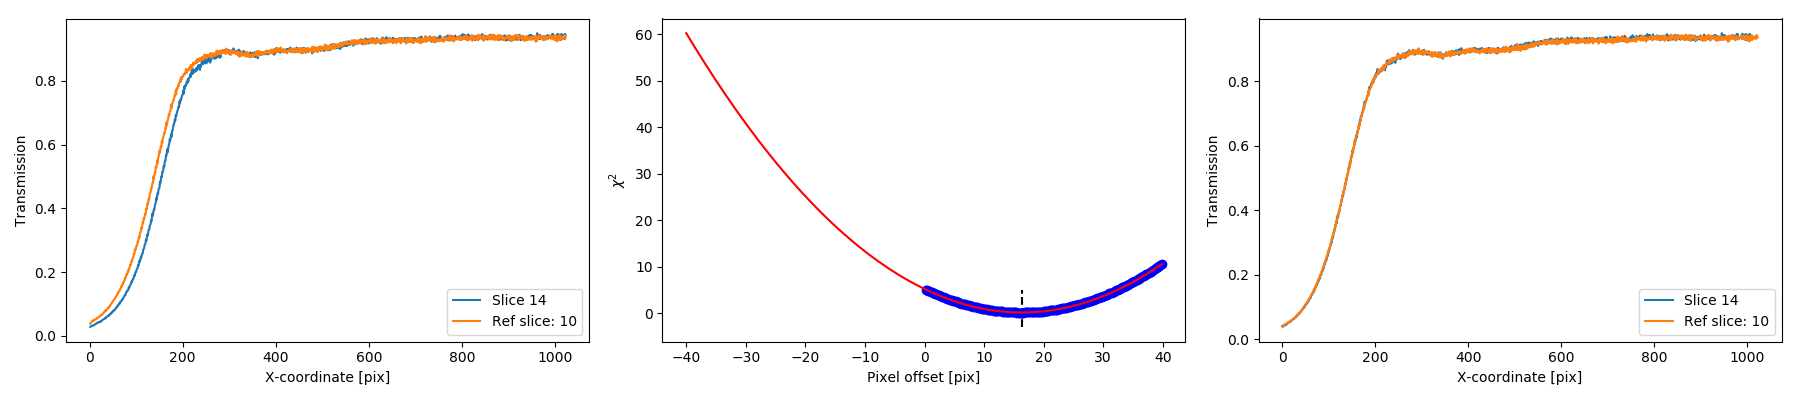

Slice 14
Pixel offset: 16.36pix


<IPython.core.display.Javascript object>


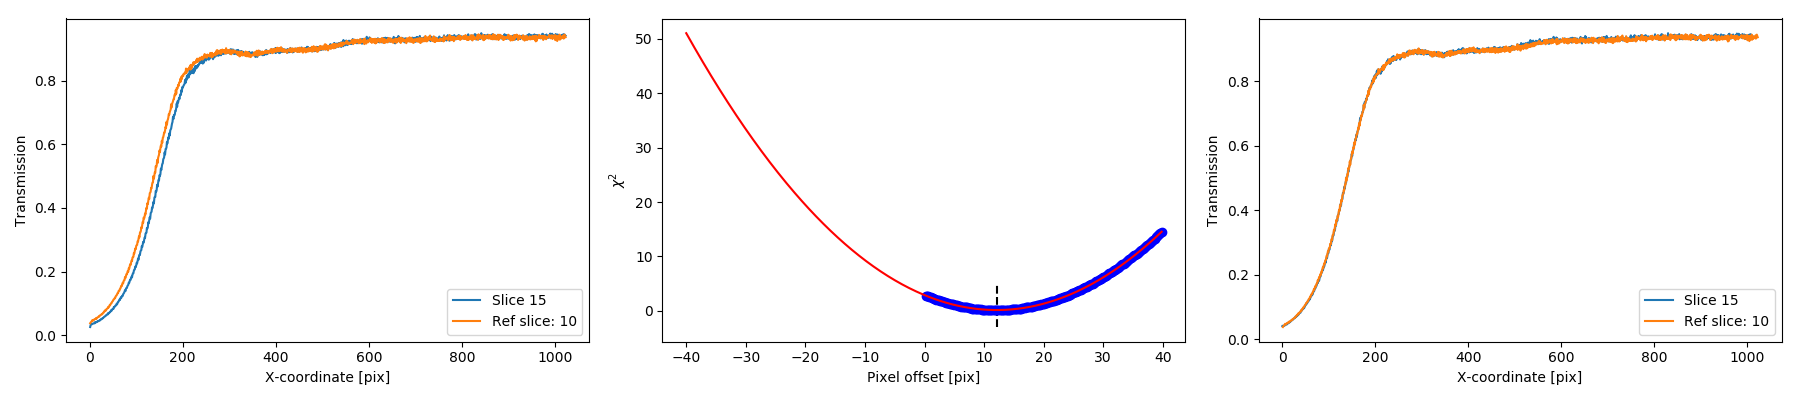

Slice 15
Pixel offset: 12.1pix


<IPython.core.display.Javascript object>


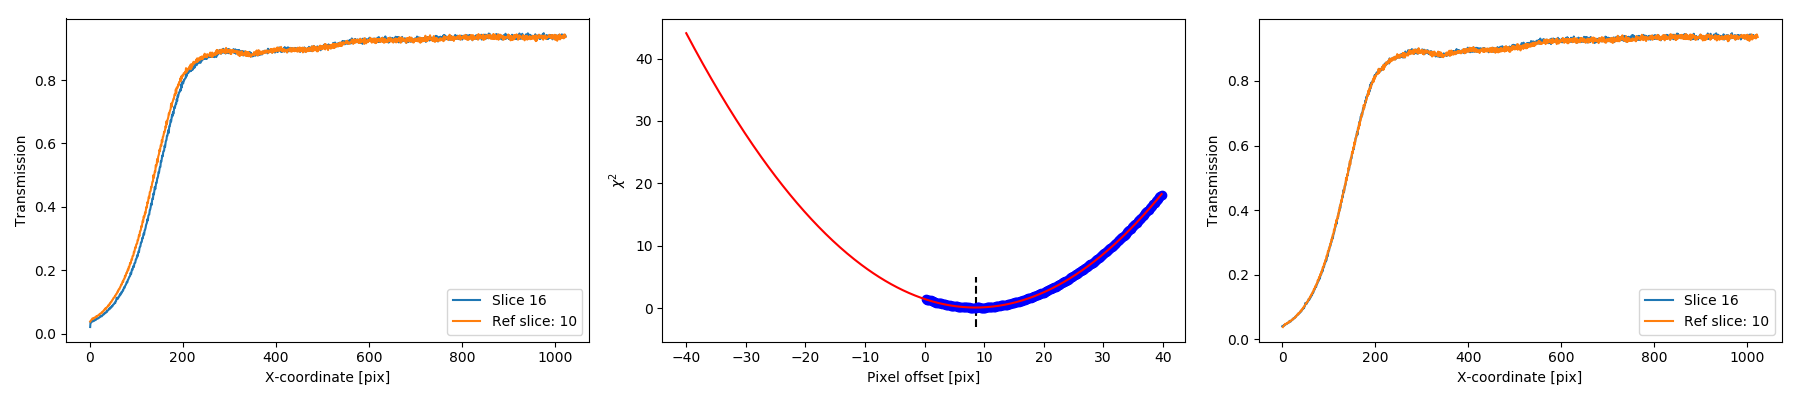

Slice 16
Pixel offset: 8.57pix


<IPython.core.display.Javascript object>


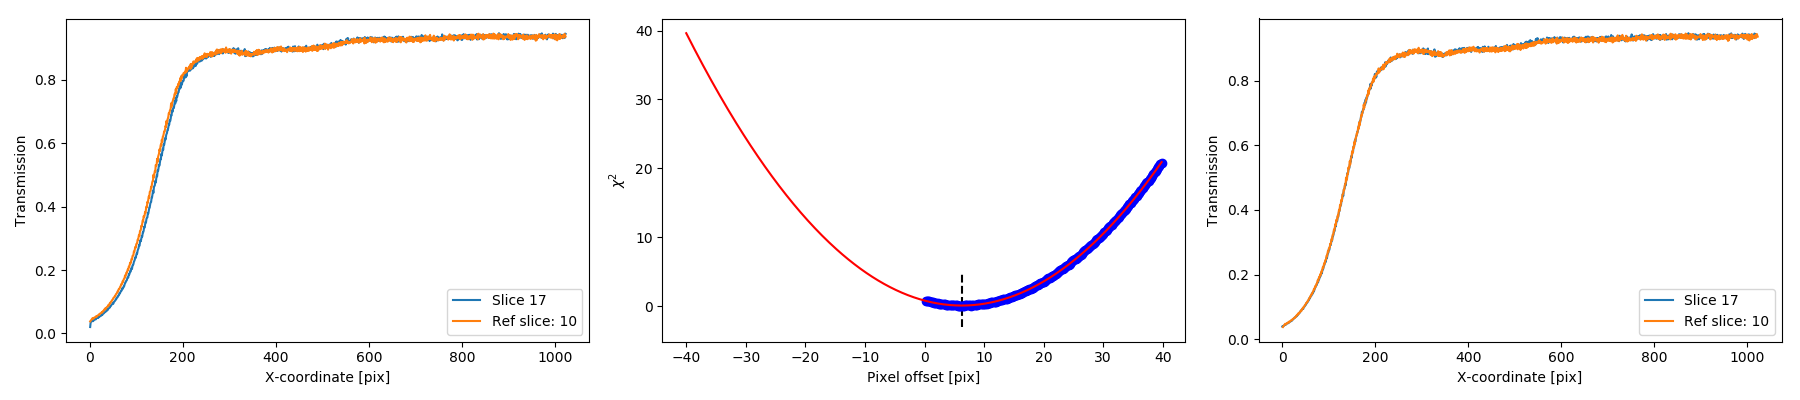

Slice 17
Pixel offset: 6.24pix


<IPython.core.display.Javascript object>


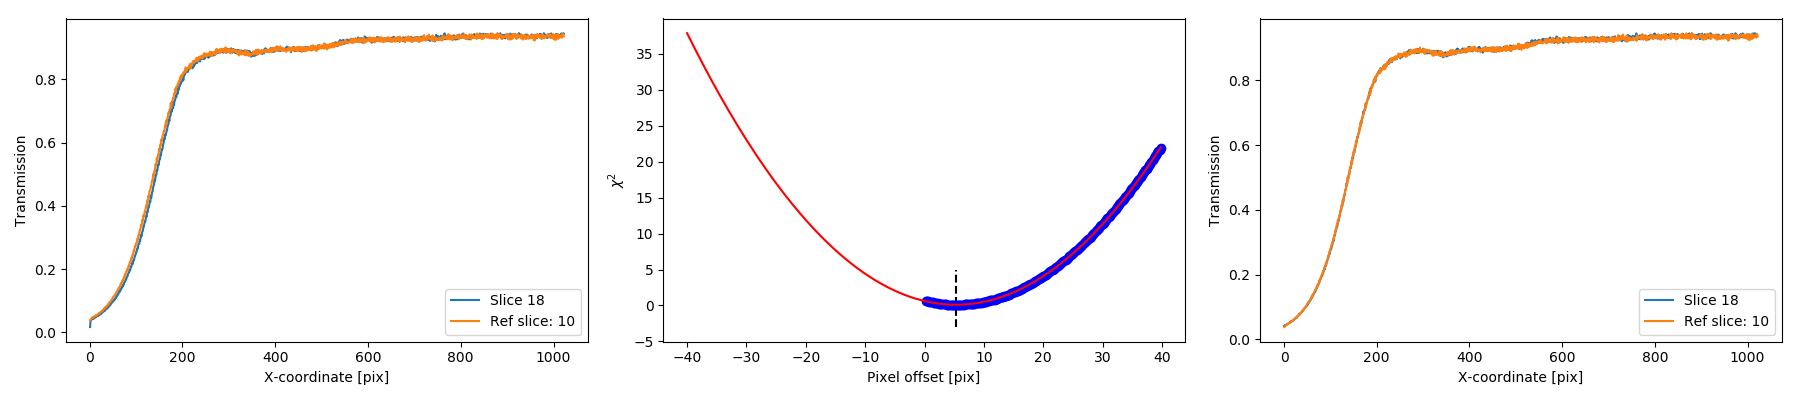

Slice 18
Pixel offset: 5.3pix


<IPython.core.display.Javascript object>


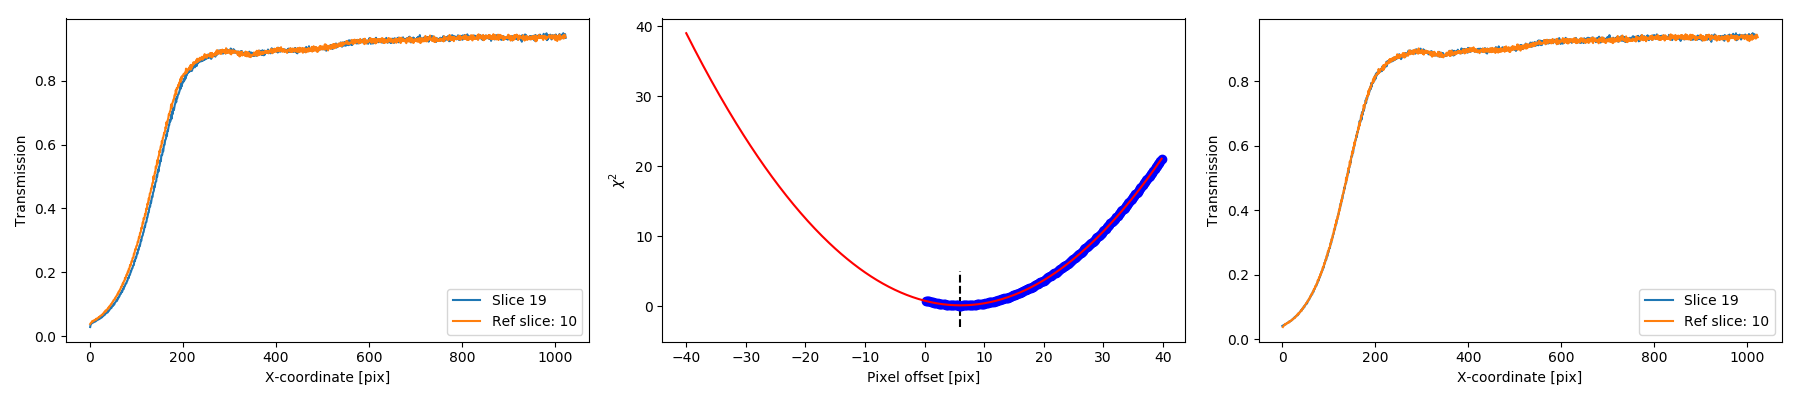

Slice 19
Pixel offset: 6.02pix


<IPython.core.display.Javascript object>


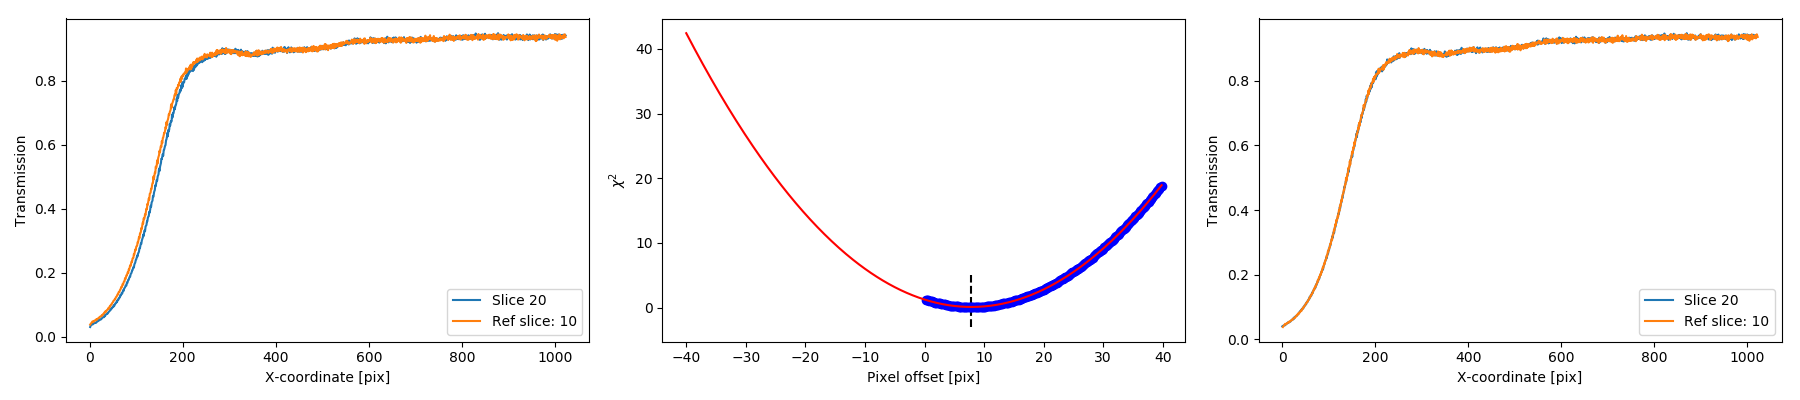

Slice 20
Pixel offset: 7.87pix


<IPython.core.display.Javascript object>


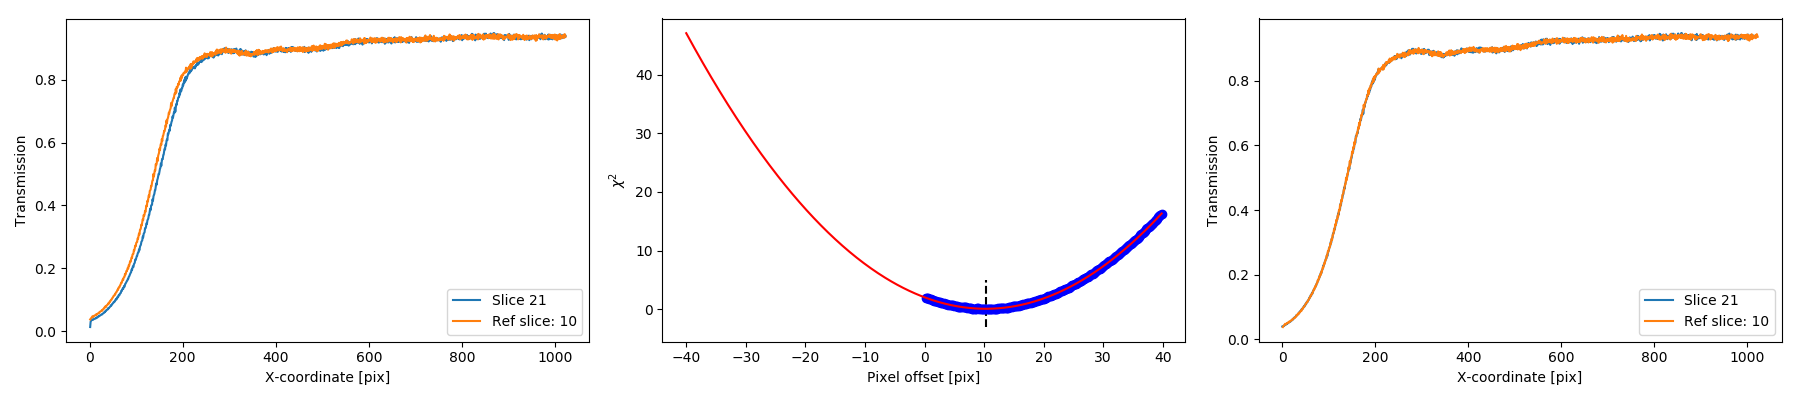

Slice 21
Pixel offset: 10.25pix


In [190]:
plt.close('all')
ypos_ref,xpos_ref = funcs.detpixel_trace(band,d2cMaps,sliceID=ref_slice,alpha_pos=alpha_pos)
sci_fm_data_ref = lwp_transmission_img[ypos_ref,xpos_ref]

# create a finer grid
step = 0.2
fine_grid = np.arange(0,1023+step,step)
sci_fm_data_ref_fine = interp1d(np.arange(len(sci_fm_data_ref)),sci_fm_data_ref)(fine_grid)

pix_offsets = []
offsets = np.arange(1,200)
wider_offsets = np.arange(-200,200)
# plot = True
for islice in range(1,nslices+1):
# for islice in [13]:
    if islice == 10:
        pix_offset = 0.
        pix_offsets.append(round(pix_offset,2))
        continue
    ypos,xpos = funcs.detpixel_trace(band,d2cMaps,sliceID=islice,alpha_pos=alpha_pos)
    sci_fm_data = lwp_transmission_img[ypos,xpos]

    sci_fm_data_fine = interp1d(np.arange(len(sci_fm_data)),sci_fm_data)(fine_grid)
    
    if (lambdaMap[ypos_ref,xpos_ref][len(ypos)/2] - lambdaMap[ypos,xpos][len(ypos)/2]) > 0. :
        residuals = []
        for offset in offsets:
            residuals.append(np.sum(((sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])[~np.isnan(sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])])[:-300]**2))
        residuals = np.array(residuals)

        popt     = np.polyfit(offsets,residuals,2)
        poly     = np.poly1d(popt)
        
        pix_offset = -popt[1]/(2.*popt[0])*step
        
        if plot is True:
            fig,axs = plt.subplots(1,3,figsize=(18,4))
            axs[0].plot(fine_grid,sci_fm_data_fine,label='Slice {}'.format(islice))
            axs[0].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
            axs[1].plot(offsets*step,residuals,'bo')
            axs[1].plot(wider_offsets*step,poly(wider_offsets),'r')
            axs[1].vlines(pix_offset,-3,5,'k',linestyle='dashed')
            axs[2].plot(fine_grid[:len(sci_fm_data_fine[np.argmin(poly(offsets)):])],sci_fm_data_fine[np.argmin(poly(offsets)):],label='Slice {}'.format(islice))
            axs[2].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
            for iplot in [0,2]:
                axs[iplot].set_xlabel('X-coordinate [pix]')
                axs[iplot].set_ylabel('Transmission')
                axs[iplot].legend(loc='lower right')
            axs[1].set_xlabel('Pixel offset [pix]')
            axs[1].set_ylabel(r'$\chi$$^2$')
            plt.tight_layout()
    elif (lambdaMap[ypos_ref,xpos_ref][len(ypos)/2] - lambdaMap[ypos,xpos][len(ypos)/2]) < 0. :
        residuals = []
        for offset in offsets:
            residuals.append(np.sum(((sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])[~np.isnan(sci_fm_data_fine[offset:]-sci_fm_data_ref_fine[:-offset])])[:-300]**2))
        residuals = np.array(residuals)

        popt     = np.polyfit(offsets,residuals,2)
        poly     = np.poly1d(popt)
        
        pix_offset = -popt[1]/(2.*popt[0])*step
        
        if plot is True:
            fig,axs = plt.subplots(1,3,figsize=(18,4))
            axs[0].plot(fine_grid,sci_fm_data_fine,label='Slice {}'.format(islice))
            axs[0].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
            axs[1].plot(offsets*step,residuals,'bo')
            axs[1].plot(wider_offsets*step,poly(wider_offsets),'r')
            axs[1].vlines(pix_offset,0-3,5,'k',linestyle='dashed')
            axs[2].plot(fine_grid[:len(sci_fm_data_fine[np.argmin(poly(offsets)):])],sci_fm_data_fine[np.argmin(poly(offsets)):],label='Slice {}'.format(islice))
            axs[2].plot(fine_grid,sci_fm_data_ref_fine,label='Ref slice: {}'.format(ref_slice))
            for iplot in [0,2]:
                axs[iplot].set_xlabel('X-coordinate [pix]')
                axs[iplot].set_ylabel('Transmission')
                axs[iplot].legend(loc='lower right')
            axs[1].set_xlabel('Pixel offset [pix]')
            axs[1].set_ylabel(r'$\chi$$^2$')
            plt.tight_layout()
    pix_offsets.append(round(pix_offset,2))
    print 'Slice {}'.format(islice)
    print 'Pixel offset: {}pix'.format(pix_offsets[islice-1])

In [ ]:
# save output
save_file = open('data/Band'+str(band)+'_LWP_refslice'+str(ref_slice)+'_alpha'+str(alpha_pos)+'_reloffsets.txt', 'w')
save_file.write('# Band '+str(band)+'   Filter LWP   RefSlice '+str(ref_slice)+'\n')
save_file.write('# Distortion map version 06.04.00 - date '+str(date.today())+'\n')
save_file.write('# Trace (isoalpha): Take pixel trace along specified slice, specified alpha position trace is built by taking the pixel in every detector row with alpha value closest to the one specified \n')
save_file.write('# xpos[i] = np.argmin(alpha_img[i,:])+funcs.find_nearest(alpha_img[i,:][(slice_img[i,:]!=0)],alpha_pos)\n')
save_file.write('# Band'+str(band)+'_LWP_refslice'+str(ref_slice)+'_alpha'+str(alpha_pos)+'\n')
save_file.write('\n')
save_file.write('# Slice Nr.  Pixel offset (pix)\n')

for zzz in range(1,nslices+1):
    save_file.write(str(zzz)+'  '+str(pix_offsets[zzz-1])+'\n')
save_file.close()